IMPORTS

In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Activation, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler, LabelEncoder
from jinja2 import Template
import matplotlib.pyplot as plt
import os
!pip install scapy
from scapy.all import rdpcap , IP, TCP


converting wireshark logs file into csv


In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
packets = rdpcap('/content/drive/MyDrive/Colab Notebooks/network_logs.pcap')

In [218]:
def extract_packet_info(packet):
    packet_info = {
        'time': packet.time,
        'src_ip': packet[IP].src if IP in packet else None,
        'dst_ip': packet[IP].dst if IP in packet else None,
        'src_mac': packet.src ,
        'dst_mac': packet.dst ,
        'src_port': packet[TCP].sport if TCP in packet else None, # Check if TCP layer is present
        'dst_port': packet[TCP].dport if TCP in packet else None, # Check if TCP layer is present
        'protocol': packet[0][1].proto , # Changed 1 to IP
        'length': len(packet),
        'tcp_flags': packet.sprintf('%TCP.flags%') ,
        'ttl': packet[IP].ttl if IP in packet else None,
        'id': packet[IP].id if IP in packet else None,
        'seq': packet[TCP].seq if TCP in packet else None, # Check if TCP layer is present
        'ack': packet[TCP].ack if TCP in packet else None, # Check if TCP layer is present
        'payload': bytes(packet.payload).hex()
    }
    return packet_info

# Извлечение информации из всех пакетов
packet_data = [extract_packet_info(packet) for packet in packets]

# Создание DataFrame из извлеченной информации
df = pd.DataFrame(packet_data)

# Сохранение DataFrame в CSV файл
df.to_csv('output.csv', index=False)

print("Преобразование завершено. Данные сохранены в output.csv")

Преобразование завершено. Данные сохранены в output.csv


In [219]:
df = pd.read_csv('output.csv')
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload
0,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,NaN,NaN,17,110,??,128,9,NaN,NaN,45000060000900008011d0f5ac11086dac1108ff008900...
1,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,NaN,NaN,17,110,??,128,10,NaN,NaN,45000060000a00008011d0f4ac11086dac1108ff008900...
2,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,NaN,NaN,17,97,??,128,12,NaN,NaN,45000053000c00008011d1fcac11086dac110802c3c000...
3,1.548712e+09,172.17.8.2,172.17.8.109,00:21:5e:72:9e:b4,14:fe:b5:d4:15:ca,NaN,NaN,17,164,??,128,14525,NaN,NaN,4500009638bd000080119908ac110802ac11086d0035c3...
4,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,NaN,NaN,17,91,??,128,13,NaN,NaN,4500004d000d00008011d201ac11086dac110802e09400...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,A,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...
3686,1.548713e+09,216.239.94.252,172.17.8.109,00:04:9a:58:eb:0d,14:fe:b5:d4:15:ca,443.0,49234.0,6,54,FPA,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...
3687,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,A,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...
3688,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,FA,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...


CLEANING DATA


In [220]:
unique_flags = sorted(set(flag for flags in df['tcp_flags'] for flag in flags if flag != '?'))
print(unique_flags)

['A', 'F', 'P', 'R', 'S']


In [221]:
flag_values = {
    'F': 1,
    'S': 2,
    'R': 4,
    'P': 8,
    'A': 16,
    'Unknown': 32  # Assign a value for Unknown
}

# Function to convert flags to numeric representation
def convert_flags_to_num(flags):
    num_value = 0
    if '??' in flags:
        num_value += flag_values['Unknown']
    for flag in flag_values:
        if flag in flags:
            num_value += flag_values[flag]
    return num_value

# Apply the function to the 'tcp_flags' column
df['tcp_flags'] = df['tcp_flags'].apply(convert_flags_to_num)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload
0,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,NaN,NaN,17,110,32,128,9,NaN,NaN,45000060000900008011d0f5ac11086dac1108ff008900...
1,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,NaN,NaN,17,110,32,128,10,NaN,NaN,45000060000a00008011d0f4ac11086dac1108ff008900...
2,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,NaN,NaN,17,97,32,128,12,NaN,NaN,45000053000c00008011d1fcac11086dac110802c3c000...
3,1.548712e+09,172.17.8.2,172.17.8.109,00:21:5e:72:9e:b4,14:fe:b5:d4:15:ca,NaN,NaN,17,164,32,128,14525,NaN,NaN,4500009638bd000080119908ac110802ac11086d0035c3...
4,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,NaN,NaN,17,91,32,128,13,NaN,NaN,4500004d000d00008011d201ac11086dac110802e09400...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...
3686,1.548713e+09,216.239.94.252,172.17.8.109,00:04:9a:58:eb:0d,14:fe:b5:d4:15:ca,443.0,49234.0,6,54,25,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...
3687,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...
3688,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,17,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...


In [222]:
df['src_port_missing'] = df['src_port'].isnull().astype(int)
df['dst_port_missing'] = df['dst_port'].isnull().astype(int)
       # Then fill the original columns with -1
df['src_port'].fillna(-1, inplace=True)
df['dst_port'].fillna(-1, inplace=True)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload,src_port_missing,dst_port_missing
0,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,-1.0,-1.0,17,110,32,128,9,NaN,NaN,45000060000900008011d0f5ac11086dac1108ff008900...,1,1
1,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,-1.0,-1.0,17,110,32,128,10,NaN,NaN,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1
2,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,-1.0,-1.0,17,97,32,128,12,NaN,NaN,45000053000c00008011d1fcac11086dac110802c3c000...,1,1
3,1.548712e+09,172.17.8.2,172.17.8.109,00:21:5e:72:9e:b4,14:fe:b5:d4:15:ca,-1.0,-1.0,17,164,32,128,14525,NaN,NaN,4500009638bd000080119908ac110802ac11086d0035c3...,1,1
4,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,-1.0,-1.0,17,91,32,128,13,NaN,NaN,4500004d000d00008011d201ac11086dac110802e09400...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0
3686,1.548713e+09,216.239.94.252,172.17.8.109,00:04:9a:58:eb:0d,14:fe:b5:d4:15:ca,443.0,49234.0,6,54,25,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0
3687,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0
3688,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,17,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0


In [223]:
df['seq_missing'] = df['seq'].isnull().astype(int)
df['ack_missing'] = df['ack'].isnull().astype(int)
df['seq'].fillna(-1, inplace=True)
df['ack'].fillna(-1, inplace=True)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload,src_port_missing,dst_port_missing,seq_missing,ack_missing
0,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,-1.0,-1.0,17,110,32,128,9,-1.000000e+00,-1.000000e+00,45000060000900008011d0f5ac11086dac1108ff008900...,1,1,1,1
1,1.548712e+09,172.17.8.109,172.17.8.255,14:fe:b5:d4:15:ca,ff:ff:ff:ff:ff:ff,-1.0,-1.0,17,110,32,128,10,-1.000000e+00,-1.000000e+00,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1,1,1
2,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,-1.0,-1.0,17,97,32,128,12,-1.000000e+00,-1.000000e+00,45000053000c00008011d1fcac11086dac110802c3c000...,1,1,1,1
3,1.548712e+09,172.17.8.2,172.17.8.109,00:21:5e:72:9e:b4,14:fe:b5:d4:15:ca,-1.0,-1.0,17,164,32,128,14525,-1.000000e+00,-1.000000e+00,4500009638bd000080119908ac110802ac11086d0035c3...,1,1,1,1
4,1.548712e+09,172.17.8.109,172.17.8.2,14:fe:b5:d4:15:ca,00:21:5e:72:9e:b4,-1.0,-1.0,17,91,32,128,13,-1.000000e+00,-1.000000e+00,4500004d000d00008011d201ac11086dac110802e09400...,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0,0,0
3686,1.548713e+09,216.239.94.252,172.17.8.109,00:04:9a:58:eb:0d,14:fe:b5:d4:15:ca,443.0,49234.0,6,54,25,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0,0,0
3687,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,16,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0,0,0
3688,1.548713e+09,172.17.8.109,216.239.94.252,14:fe:b5:d4:15:ca,00:04:9a:58:eb:0d,49234.0,443.0,6,54,17,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0,0,0


In [224]:
nan_columns = df.columns[df.isna().any()].tolist()
if len(nan_columns) ==0:
  print("No NaN colums left")
else:
  print("all good")

No NaN colums left


In [225]:
df['src_mac'] = df['src_mac'].apply(lambda x: int(x.replace(':', ''), 16) if x is not None else -1)
df['dst_mac'] = df['dst_mac'].apply(lambda x: int(x.replace(':', ''), 16) if x is not None else -1)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload,src_port_missing,dst_port_missing,seq_missing,ack_missing
0,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,128,9,-1.000000e+00,-1.000000e+00,45000060000900008011d0f5ac11086dac1108ff008900...,1,1,1,1
1,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,128,10,-1.000000e+00,-1.000000e+00,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1,1,1
2,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,97,32,128,12,-1.000000e+00,-1.000000e+00,45000053000c00008011d1fcac11086dac110802c3c000...,1,1,1,1
3,1.548712e+09,172.17.8.2,172.17.8.109,143318490804,23084204824010,-1.0,-1.0,17,164,32,128,14525,-1.000000e+00,-1.000000e+00,4500009638bd000080119908ac110802ac11086d0035c3...,1,1,1,1
4,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,91,32,128,13,-1.000000e+00,-1.000000e+00,4500004d000d00008011d201ac11086dac110802e09400...,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0,0,0
3686,1.548713e+09,216.239.94.252,172.17.8.109,19769387789,23084204824010,443.0,49234.0,6,54,25,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0,0,0
3687,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0,0,0
3688,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,17,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0,0,0


we add more colums related to ip addr (if the conn is local, etc...)

In [226]:
import ipaddress
company_ips = ['172.17.8.0/24']  # Example company IP ranges

def is_internal_ip(ip):
    if ip is None:
        return False
    ip_obj = ipaddress.ip_address(ip)
    for network in company_ips:
        if ip_obj in ipaddress.ip_network(network):
            return True
    return False

df['internal_conn'] = ((df['src_ip'].apply(is_internal_ip)) & (df['dst_ip'].apply(is_internal_ip))).astype(int)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,ttl,id,seq,ack,payload,src_port_missing,dst_port_missing,seq_missing,ack_missing,internal_conn
0,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,128,9,-1.000000e+00,-1.000000e+00,45000060000900008011d0f5ac11086dac1108ff008900...,1,1,1,1,1
1,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,128,10,-1.000000e+00,-1.000000e+00,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1,1,1,1
2,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,97,32,128,12,-1.000000e+00,-1.000000e+00,45000053000c00008011d1fcac11086dac110802c3c000...,1,1,1,1,1
3,1.548712e+09,172.17.8.2,172.17.8.109,143318490804,23084204824010,-1.0,-1.0,17,164,32,128,14525,-1.000000e+00,-1.000000e+00,4500009638bd000080119908ac110802ac11086d0035c3...,1,1,1,1,1
4,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,91,32,128,13,-1.000000e+00,-1.000000e+00,4500004d000d00008011d201ac11086dac110802e09400...,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,128,1644,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0,0,0,0
3686,1.548713e+09,216.239.94.252,172.17.8.109,19769387789,23084204824010,443.0,49234.0,6,54,25,128,42450,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0,0,0,0
3687,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,128,1645,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0,0,0,0
3688,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,17,128,1646,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0,0,0,0


add key devices colums (if traffic comes from hubs/gateways etc)

In [227]:
df['dc_conn'] = ((df['src_ip'] == '172.17.8.2') | (df['dst_ip'] == '172.17.8.2')).astype(int)
df['gateway_conn'] = ((df['src_ip'] == '172.17.8.1') | (df['dst_ip'] == '172.17.8.1')).astype(int)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,...,seq,ack,payload,src_port_missing,dst_port_missing,seq_missing,ack_missing,internal_conn,dc_conn,gateway_conn
0,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,...,-1.000000e+00,-1.000000e+00,45000060000900008011d0f5ac11086dac1108ff008900...,1,1,1,1,1,0,0
1,1.548712e+09,172.17.8.109,172.17.8.255,23084204824010,281474976710655,-1.0,-1.0,17,110,32,...,-1.000000e+00,-1.000000e+00,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1,1,1,1,0,0
2,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,97,32,...,-1.000000e+00,-1.000000e+00,45000053000c00008011d1fcac11086dac110802c3c000...,1,1,1,1,1,1,0
3,1.548712e+09,172.17.8.2,172.17.8.109,143318490804,23084204824010,-1.0,-1.0,17,164,32,...,-1.000000e+00,-1.000000e+00,4500009638bd000080119908ac110802ac11086d0035c3...,1,1,1,1,1,1,0
4,1.548712e+09,172.17.8.109,172.17.8.2,23084204824010,143318490804,-1.0,-1.0,17,91,32,...,-1.000000e+00,-1.000000e+00,4500004d000d00008011d201ac11086dac110802e09400...,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,...,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0,0,0,0,0,0
3686,1.548713e+09,216.239.94.252,172.17.8.109,19769387789,23084204824010,443.0,49234.0,6,54,25,...,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0,0,0,0,0,0
3687,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,16,...,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0,0,0,0,0,0
3688,1.548713e+09,172.17.8.109,216.239.94.252,23084204824010,19769387789,49234.0,443.0,6,54,17,...,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0,0,0,0,0,0


converting ip

In [228]:
df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x is not None else -1)
df['dst_ip'] = df['dst_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x is not None else -1)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,...,seq,ack,payload,src_port_missing,dst_port_missing,seq_missing,ack_missing,internal_conn,dc_conn,gateway_conn
0,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,...,-1.000000e+00,-1.000000e+00,45000060000900008011d0f5ac11086dac1108ff008900...,1,1,1,1,1,0,0
1,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,...,-1.000000e+00,-1.000000e+00,45000060000a00008011d0f4ac11086dac1108ff008900...,1,1,1,1,1,0,0
2,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,97,32,...,-1.000000e+00,-1.000000e+00,45000053000c00008011d1fcac11086dac110802c3c000...,1,1,1,1,1,1,0
3,1.548712e+09,2886797314,2886797421,143318490804,23084204824010,-1.0,-1.0,17,164,32,...,-1.000000e+00,-1.000000e+00,4500009638bd000080119908ac110802ac11086d0035c3...,1,1,1,1,1,1,0
4,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,91,32,...,-1.000000e+00,-1.000000e+00,4500004d000d00008011d201ac11086dac110802e09400...,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,...,2.878876e+09,1.990931e+09,45000028066c4000800607faac11086dd8ef5efcc05201...,0,0,0,0,0,0,0
3686,1.548713e+09,3639566076,2886797421,19769387789,23084204824010,443.0,49234.0,6,54,25,...,1.990931e+09,2.878876e+09,45000028a5d200008006a893d8ef5efcac11086d01bbc0...,0,0,0,0,0,0,0
3687,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,...,2.878876e+09,1.990931e+09,45000028066d4000800607f9ac11086dd8ef5efcc05201...,0,0,0,0,0,0,0
3688,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,17,...,2.878876e+09,1.990931e+09,45000028066e4000800607f8ac11086dd8ef5efcc05201...,0,0,0,0,0,0,0


convert seq and ack with scaler (to normalize the values)

In [229]:
if 'ttl' in df.columns:
    df.drop(columns=['ttl'], inplace=True)
if 'payload' in df.columns:
    df.drop(columns=['payload'], inplace=True)
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,id,seq,ack,src_port_missing,dst_port_missing,seq_missing,ack_missing,internal_conn,dc_conn,gateway_conn
0,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,9,-1.000000e+00,-1.000000e+00,1,1,1,1,1,0,0
1,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,10,-1.000000e+00,-1.000000e+00,1,1,1,1,1,0,0
2,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,97,32,12,-1.000000e+00,-1.000000e+00,1,1,1,1,1,1,0
3,1.548712e+09,2886797314,2886797421,143318490804,23084204824010,-1.0,-1.0,17,164,32,14525,-1.000000e+00,-1.000000e+00,1,1,1,1,1,1,0
4,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,91,32,13,-1.000000e+00,-1.000000e+00,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1644,2.878876e+09,1.990931e+09,0,0,0,0,0,0,0
3686,1.548713e+09,3639566076,2886797421,19769387789,23084204824010,443.0,49234.0,6,54,25,42450,1.990931e+09,2.878876e+09,0,0,0,0,0,0,0
3687,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1645,2.878876e+09,1.990931e+09,0,0,0,0,0,0,0
3688,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,17,1646,2.878876e+09,1.990931e+09,0,0,0,0,0,0,0


In [230]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['seq', 'ack']] = scaler.fit_transform(df[['seq', 'ack']])
df

,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,id,seq,ack,src_port_missing,dst_port_missing,seq_missing,ack_missing,internal_conn,dc_conn,gateway_conn
0,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,9,0.000000,0.000000,1,1,1,1,1,0,0
1,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,10,0.000000,0.000000,1,1,1,1,1,0,0
2,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,97,32,12,0.000000,0.000000,1,1,1,1,1,1,0
3,1.548712e+09,2886797314,2886797421,143318490804,23084204824010,-1.0,-1.0,17,164,32,14525,0.000000,0.000000,1,1,1,1,1,1,0
4,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,91,32,13,0.000000,0.000000,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1644,0.673848,0.466010,0,0,0,0,0,0,0
3686,1.548713e+09,3639566076,2886797421,19769387789,23084204824010,443.0,49234.0,6,54,25,42450,0.466010,0.673848,0,0,0,0,0,0,0
3687,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1645,0.673848,0.466010,0,0,0,0,0,0,0
3688,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,17,1646,0.673848,0.466010,0,0,0,0,0,0,0


now proceed with model definition

Epoch 1/100
3/3 [==============================] - 9s 606ms/step - loss: 150994679917216964760567808.0000 - val_loss: 158594646241864931478601728.0000
Epoch 2/100
3/3 [==============================] - 0s 186ms/step - loss: 150994698363961038470119424.0000 - val_loss: 158594646241864931478601728.0000
Epoch 3/100
3/3 [==============================] - 1s 225ms/step - loss: 150994698363961038470119424.0000 - val_loss: 158594646241864931478601728.0000
Epoch 4/100
3/3 [==============================] - 1s 296ms/step - loss: 150994698363961038470119424.0000 - val_loss: 158594646241864931478601728.0000
Epoch 5/100
3/3 [==============================] - 1s 194ms/step - loss: 150994624576984743631912960.0000 - val_loss: 158594646241864931478601728.0000
Epoch 6/100
3/3 [==============================] - 1s 283ms/step - loss: 150994726034077149034446848.0000 - val_loss: 158594646241864931478601728.0000
Epoch 7/100
3/3 [==============================] - 1s 295ms/step - loss: 150994698363961038470

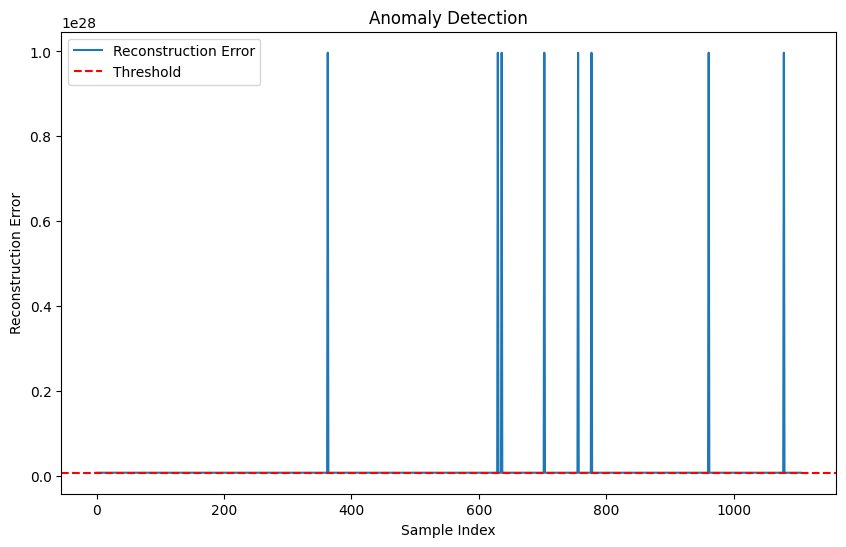

In [249]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam

class AutoencoderModel:
    def __init__(self, input_shape, encoding_dim, learning_rate=0.001):
        self.input_shape = input_shape
        self.encoding_dim = encoding_dim
        self.learning_rate = learning_rate
        self.model, self.encoder = self.build_model()
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

    def build_model(self):
        # Encoder
        inputs = Input(shape=self.input_shape)
        x = LSTM(128, activation='relu', return_sequences=True)(inputs)
        x = LSTM(self.encoding_dim, activation='relu')(x)

        # Decoder
        x = RepeatVector(self.input_shape[0])(x)
        x = LSTM(128, activation='relu', return_sequences=True)(x)
        outputs = LSTM(self.input_shape[1], activation='sigmoid', return_sequences=True)(x)

        model = Model(inputs, outputs)
        encoder = Model(inputs, x)
        return model, encoder

# Prepare your data
from sklearn.model_selection import train_test_split

def prepare_data(df, target_columns):
    X = df.drop(columns=target_columns)
    y = df[target_columns]
    return X, y

target_columns = ['protocol', 'length', 'tcp_flags', 'seq', 'ack','src_port_missing', 'dst_port_missing', 'seq_missing', 'ack_missing','internal_conn', 'dc_conn','gateway_conn']
X, y = prepare_data(df, target_columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

# Reshape data for LSTM (if needed)
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Initialize and train the model
autoencoder = AutoencoderModel(input_shape=(X_train.shape[1], X_train.shape[2]), encoding_dim=32)

# Train model
history = autoencoder.model.fit(X_train, X_train, epochs=100, batch_size=512, validation_split=0.5)

# Detect anomalies
reconstructions = autoencoder.model.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

# Define threshold for anomaly detection
threshold = np.percentile(mse, 98)  # Adjust percentile as needed
anomalies = mse > threshold
# Extract anomaly indices
anomaly_indices = np.where(anomalies)[0]
# Get anomalies from the original DataFrame
anomalous_data = df.iloc[X_test.shape[0] - len(X_test) + anomaly_indices]

# Display the anomalies
print("Anomalies detected:")
print(anomalous_data[['time', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'src_port', 'dst_port', 'protocol', 'length', 'tcp_flags', 'id', 'seq', 'ack', 'internal_conn', 'dc_conn', 'gateway_conn']])

# Optional: Visualize reconstruction error
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection')
plt.legend()
plt.show()


In [250]:
# Convert back to original format for anomalies
def convert_ip_back(num_ip):
    try:
        return str(ipaddress.IPv4Address(num_ip))
    except:
        return None

def convert_mac_back(num_mac):
    if pd.isna(num_mac) or num_mac == -1:  # Handle missing data
        return None
    try:
        # Ensure num_mac is an integer
        num_mac = int(num_mac)
        # Format the MAC address as 12 hexadecimal digits (or less if num_mac is too small)
        hex_str = f'{num_mac:012x}'[:12]
        # Split into pairs with colons
        mac_address = ':'.join(hex_str[i:i+2] for i in range(0, len(hex_str), 2))
        return mac_address
    except Exception as e:
        print(f"Error converting MAC: {e}, Value: {num_mac}")
        return None

# Map numerical data back to original formats
anomalous_data['time'] = pd.to_datetime(anomalous_data['time'], unit='s')
anomalous_data['src_ip'] = anomalous_data['src_ip'].apply(convert_ip_back)
anomalous_data['dst_ip'] = anomalous_data['dst_ip'].apply(convert_ip_back)
anomalous_data['src_mac'] = anomalous_data['src_mac'].apply(convert_mac_back)
anomalous_data['dst_mac'] = anomalous_data['dst_mac'].apply(convert_mac_back)

# Display the anomalies with original formatting
print("Anomalies detected:")
print(anomalous_data[['time', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'src_port', 'dst_port', 'protocol', 'length', 'tcp_flags', 'id', 'seq', 'ack', 'internal_conn', 'dc_conn', 'gateway_conn']])


Anomalies detected:
                              time           src_ip         dst_ip  \
10   2019-01-28 21:44:14.170068992     172.17.8.109     172.17.8.2   
26   2019-01-28 21:44:14.192699904       172.17.8.2   172.17.8.109   
27   2019-01-28 21:44:14.192699904       172.17.8.2   172.17.8.109   
93   2019-01-28 21:44:14.291858944     172.17.8.109     172.17.8.2   
220  2019-01-28 21:44:15.169318912       172.17.8.2   172.17.8.109   
306  2019-01-28 21:44:15.419748096     172.17.8.109     172.17.8.2   
321  2019-01-28 21:44:15.421592832     172.17.8.109     172.17.8.2   
363  2019-01-28 21:44:15.430737920     172.17.8.109     172.17.8.2   
425  2019-01-28 21:44:17.457724160     172.17.8.109     172.17.8.2   
515  2019-01-28 21:44:25.048150016       172.17.8.2   172.17.8.109   
528  2019-01-28 21:44:31.107523840       172.17.8.2   172.17.8.109   
630  2019-01-28 21:48:51.320326144     172.17.8.109     172.17.8.2   
636  2019-01-28 21:48:51.321212928       172.17.8.2   172.17.8.109   


<ipython-input-250-c39393115648>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalous_data['time'] = pd.to_datetime(anomalous_data['time'], unit='s')
<ipython-input-250-c39393115648>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalous_data['src_ip'] = anomalous_data['src_ip'].apply(convert_ip_back)
<ipython-input-250-c39393115648>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav